In [457]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

## Dataset

In [458]:
start_date = '2023-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
stock_ticker = 'NVDA'

df = yf.download(stock_ticker, start=start_date, end=end_date)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
0,2023-01-03,14.303278,14.983721,14.084457,14.838839,401277000
1,2023-01-04,14.736924,14.840839,14.229341,14.555074,431324000
2,2023-01-05,14.253320,14.552075,14.136415,14.479135,389168000
3,2023-01-06,14.846836,14.997712,14.022512,14.462151,405044000
4,2023-01-09,15.615206,16.042855,15.128604,15.271488,504231000


In [459]:
df.columns = df.columns.droplevel(1)
df.columns.name = None

df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

df = df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
df = df.reset_index(drop=True)

df.head()

,Date,Close
0,2023-01-03,14.838839
1,2023-01-04,14.555074
2,2023-01-05,14.479135
3,2023-01-06,14.462151
4,2023-01-09,15.271488


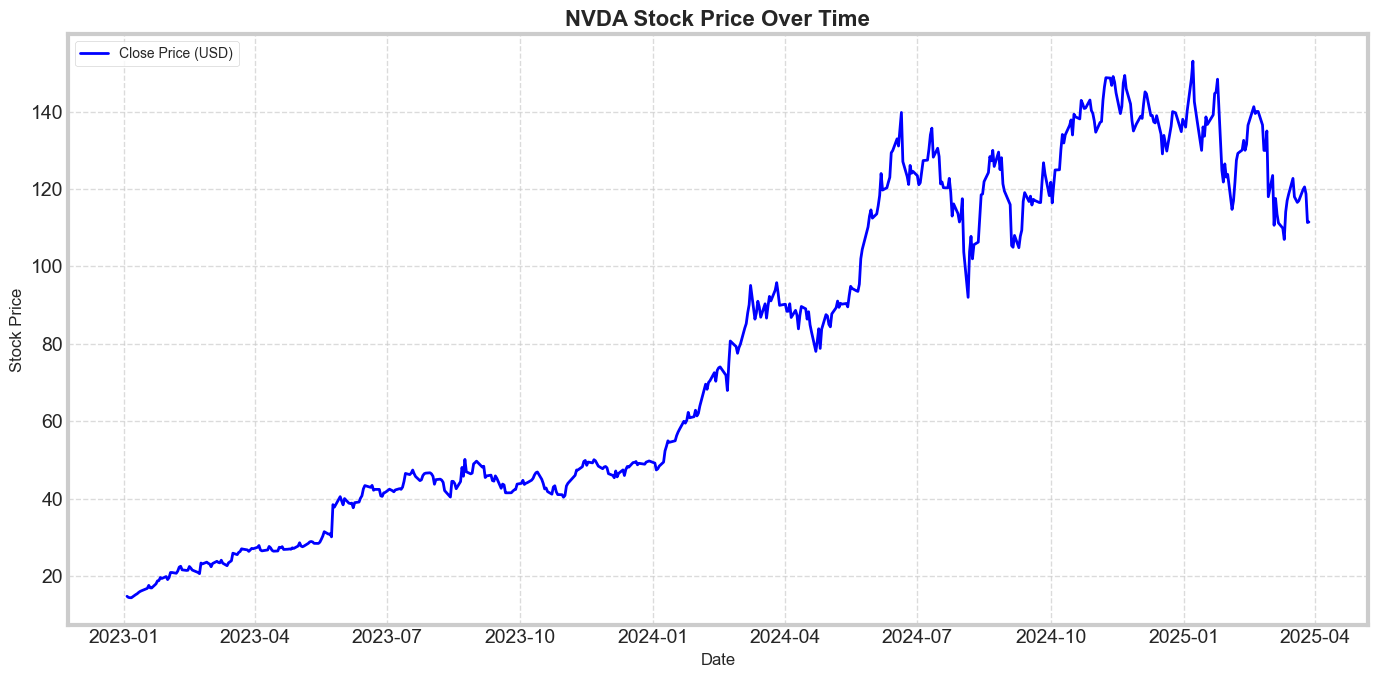

In [460]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price (USD)', color='blue', linewidth=2)
plt.title(f'{stock_ticker} Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Add features for improved model

In [461]:
def add_features(df):
  df_copy = df.copy()

  # Lagged Closing Prices
  df_copy["Close_Lag1"] = df_copy["Close"].shift(1)
  df_copy["Close_Lag2"] = df_copy["Close"].shift(2)
  df_copy["Close_Lag3"] = df_copy["Close"].shift(3)

  # Moving Averages - shift by 1 to avoid using current day
  df_copy["MA5"] = df_copy["Close"].shift(1).rolling(window=5).mean()
  df_copy["MA10"] = df_copy["Close"].shift(1).rolling(window=10).mean()
  df_copy["MA20"] = df_copy["Close"].shift(1).rolling(window=20).mean()

  # Exponential Moving Averages - shift by 1
  df_copy["EMA12"] = df_copy["Close"].shift(1).ewm(span=12, adjust=False).mean()
  df_copy["EMA26"] = df_copy["Close"].shift(1).ewm(span=26, adjust=False).mean()
  df_copy["MACD"] = df_copy["EMA12"] - df_copy["EMA26"]
  df_copy["Signal_Line"] = df_copy["MACD"].ewm(span=9, adjust=False).mean()

  # Volatility - shift by 1
  df_copy["Volatility"] = df_copy["Close"].shift(1).rolling(window=10).std()

  # Rate of Change - shift by 1
  df_copy["ROC"] = df_copy["Close"].shift(1).pct_change(periods=10) * 100
  df_copy['ROC_Acceleration'] = df_copy['ROC'].diff()
  df_copy['ROC_MA5'] = df_copy['ROC'].rolling(window=5).mean()

  return df_copy

In [462]:
df = add_features(df)
df = df.dropna()

df.tail()

,Date,Close,Close_Lag1,Close_Lag2,Close_Lag3,MA5,MA10,MA20,EMA12,EMA26,MACD,Signal_Line,Volatility,ROC,ROC_Acceleration,ROC_MA5
556,2025-03-24,119.879997,116.940002,116.550003,117.269997,118.300000,115.813005,119.204365,117.757073,121.176151,-3.419077,-3.990415,4.496607,5.124274,2.454737,2.715482
557,2025-03-25,120.550003,119.879997,116.940002,116.550003,117.728000,116.812016,118.370993,118.083677,121.080139,-2.996462,-3.791624,4.129194,9.091015,3.966741,4.656543
558,2025-03-26,118.730003,120.550003,119.879997,116.940002,118.238000,118.169000,117.900091,118.463112,121.040870,-2.577758,-3.548851,2.411667,12.684450,3.593435,5.862959
559,2025-03-27,111.349998,118.730003,120.550003,119.879997,118.530002,118.630000,117.337688,118.504172,120.869695,-2.365523,-3.312185,1.947659,4.039608,-8.644842,6.721777
560,2025-03-28,111.489998,111.349998,118.730003,120.550003,117.490001,118.062000,116.155809,117.403530,120.164532,-2.761002,-3.201949,3.006522,-4.853457,-8.893065,5.217178


## Tesla Stock Price Prediction

### Gradient Boosting Regression

In [463]:
class GradientBoostingRegressor:
    """
    Gradient Boosting Regressor with Out-of-Bag Error Estimation
    
    A custom implementation of gradient boosting for regression that combines:
    - Gradient Boosting: Sequential building of weak learners to minimize MSE loss
    - Bagging: Random sampling of training data for each tree
    - Random Subspace: Random feature selection for each tree
    - OOB Error: Using out-of-bag samples for validation
    """
    
    def __init__(self, n_trees=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample=0.8, l2_reg=0.1):
        """
        Initialize the regressor with the following parameters:
        - n_trees: Maximum number of trees in the ensemble
        - learning_rate: Step size for gradient descent
        - max_depth: Maximum depth of each decision tree
        - subsample: Fraction of samples to use for each tree (bagging)
        - colsample: Fraction of features to use for each tree (random subspace)
        - l2_reg: L2 regularization term for leaf values
        """
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None
        self.oob_scores = []
        self.training_scores = []
        self.best_n_trees = None
        self.subsample = subsample
        self.colsample = colsample
        self.l2_reg = l2_reg
        self.feature_importances_ = None
        
    def _negative_gradient(self, y, pred):
        """Calculate negative gradient for MSE loss function (y - pred)"""
        return y - pred
    
    def _build_tree(self, X, y, depth=0):
        """
        Build a decision tree using binary splitting:
        1. Find best feature and threshold for splitting
        2. Split data into left and right nodes
        3. Recursively build subtrees
        4. Apply L2 regularization to leaf values
        """
        if depth >= self.max_depth or len(set(y)) == 1:
            return np.mean(y)
        
        best_feature, best_threshold, best_mse = None, None, float('inf')
        best_split = None

        # Intializing the number of thresholds and features
        n_thresholds = 30
        n_features = X.shape[1]
        
        # Randomly select a subset of features
        for feature_idx in range(n_features):
            unique_vals = np.unique(X[:, feature_idx])
            # If the number of unique values is greater than the number of thresholds, sample the thresholds
            if len(unique_vals) > n_thresholds:
                percentiles = np.linspace(0, 100, n_thresholds)
                sampled_thresholds = np.percentile(unique_vals, percentiles)
            else:
                sampled_thresholds = unique_vals
            
            # Calculate the best split for the sampled thresholds
            for threshold in sampled_thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if not np.any(left_mask) or not np.any(right_mask):
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                left_mean, right_mean = np.mean(y_left), np.mean(y_right)
                
                # Apply L2 regularization to the leaf values
                n_left, n_right = len(y_left), len(y_right)
                left_mean_reg = left_mean * n_left / (n_left + self.l2_reg)
                right_mean_reg = right_mean * n_right / (n_right + self.l2_reg)
                
                mse = (np.sum((y_left - left_mean_reg) ** 2) + 
                       np.sum((y_right - right_mean_reg) ** 2))
                
                # Update the best split if the current split has a lower MSE
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_split = (left_mask, right_mask)
    
        if best_split is None:
            return np.mean(y)
        
        left_subtree = self._build_tree(X[best_split[0]], y[best_split[0]], depth + 1)
        right_subtree = self._build_tree(X[best_split[1]], y[best_split[1]], depth + 1)
        
        return (best_feature, best_threshold, left_subtree, right_subtree)
    
    def _predict_tree(self, tree_data, x):
        """
        Make a prediction using a single decision tree
        
        Args:
            tree_data: Tuple containing the tree and feature subset
            x: Input data point
        """
        tree, feature_subset = tree_data
        
        if feature_subset is not None:
            x_subset = x[feature_subset]
        else:
            x_subset = x
            
        if isinstance(tree, (int, float)):
            return tree
        
        feature, threshold, left_subtree, right_subtree = tree
        
        if x_subset[feature] <= threshold:
            return self._predict_tree((left_subtree, feature_subset), x)
        else:
            return self._predict_tree((right_subtree, feature_subset), x)
        
    def _calculate_mse(self, y_true, y_pred):
        """Calculate the mean squared error between true and predicted values"""
        return np.mean((y_true - y_pred) ** 2)
    
    def _should_stop_early(self, iteration):
        """Check if early stopping should be triggered based on OOB error"""
        # If there are less than 10 OOB scores, don't stop early
        if len(self.oob_scores) < 10:
            return False
        
        # Find the index of the best OOB score
        best_score_idx = np.argmin(self.oob_scores)
        self.best_n_trees = best_score_idx + 1
        
        # If the best OOB score has been reached within the patience period, stop early
        patience = 20
        if (iteration - best_score_idx) >= patience:
            return True
        
        # Check if the OOB error has plateaued within the last 10 iterations
        recent_scores = self.oob_scores[-10:]
        if len(recent_scores) >= 10:
            changes = np.diff(recent_scores)
            avg_change = np.mean(changes)
            
            # If the average change in OOB error is positive and the OOB error has plateaued, stop early
            if avg_change > 0 and (max(recent_scores) - min(recent_scores)) / (min(recent_scores) + 1e-10) < 0.5:
                return True
        
        return False
    
    def _update_feature_importance(self, tree_data):
        """Update the feature importance scores based on the tree structure"""
        tree, feature_subset = tree_data
        
        if isinstance(tree, (int, float)):
            return
        
        feature, threshold, left_subtree, right_subtree = tree
        actual_feature = feature_subset[feature] if feature_subset is not None else feature
        
        # Increment the feature importance score for the actual feature
        self.feature_importances_[actual_feature] += 1
        
        self._update_feature_importance((left_subtree, feature_subset))
        self._update_feature_importance((right_subtree, feature_subset))
        
    def fit(self, X, y):
        """
        Fit the gradient boosting model:
        1. Initialize predictions with mean of target
        2. For each iteration:
           - Calculate negative gradients (residuals)
           - Sample data points (bagging)
           - Sample features (random subspace)
           - Build tree to predict residuals
           - Update predictions
           - Calculate training and OOB error
        3. Apply early stopping if OOB error stops improving
        """
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        # Initialize with mean prediction
        self.initial_prediction = np.mean(y)
        current_predictions = np.full(n_samples, self.initial_prediction)
        
        self.trees = []
        self.training_scores = []
        self.oob_scores = []
        self.feature_importances_ = np.zeros(n_features)
        
        with tqdm(total=self.n_trees, desc="Training Progress", unit="tree") as pbar:
            for iteration in range(self.n_trees):
                # Calculate residuals (negative gradients)
                residuals = self._negative_gradient(y, current_predictions)
                
                # Random sampling of training data (Bagging)
                sample_indices = np.random.choice(n_samples, 
                                               size=int(n_samples * self.subsample), 
                                               replace=False)
                oob_indices = np.array([i for i in range(n_samples) if i not in sample_indices])
                
                X_subset = X[sample_indices]
                residuals_subset = residuals[sample_indices]
                
                # Random feature selection (Random Subspace)
                if self.colsample < 1.0:
                    feature_indices = np.random.choice(n_features, 
                                                     size=int(n_features * self.colsample), 
                                                     replace=False)
                    X_filtered = X_subset[:, feature_indices]
                else:
                    X_filtered = X_subset
                    feature_indices = None
                
                # Build tree to predict residuals
                tree = self._build_tree(X_filtered, residuals_subset)
                self.trees.append((tree, feature_indices))
                
                # Update feature importance scores
                self._update_feature_importance((tree, feature_indices))
                
                # Make predictions for all samples
                tree_predictions = np.zeros(n_samples)
                for i in range(n_samples):
                    tree_predictions[i] = self._predict_tree((tree, feature_indices), X[i])
                
                # Update predictions with learning rate
                current_predictions += self.learning_rate * tree_predictions
                
                # Calculate training error
                train_mse = self._calculate_mse(y, current_predictions)
                self.training_scores.append(train_mse)
                
                # Calculate OOB error using out-of-bag samples
                if len(oob_indices) > 0:
                    oob_predictions = current_predictions[oob_indices]
                    oob_mse = self._calculate_mse(y[oob_indices], oob_predictions)
                    self.oob_scores.append(oob_mse)
                    
                    pbar.set_postfix({
                        "train_mse": f"{train_mse:.4f}",
                        "oob_mse": f"{oob_mse:.4f}"
                    })
                    
                    # Check early stopping criteria
                    if self._should_stop_early(iteration):
                        pbar.write(f"Early stopping at iteration {iteration}. Best n_trees: {self.best_n_trees}")
                        self.trees = self.trees[:self.best_n_trees]
                        break
                else:
                    pbar.set_postfix({"train_mse": f"{train_mse:.4f}"})
                
                pbar.update(1)
        
        # Select best number of trees based on OOB error
        if self.best_n_trees is None and len(self.oob_scores) > 0:
            self.best_n_trees = np.argmin(self.oob_scores) + 1
            self.trees = self.trees[:self.best_n_trees]
        
        # Normalize feature importance scores
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)
    
    def predict(self, X):
        """
        Make predictions:
        1. Start with initial prediction (mean of training targets)
        2. Add predictions from each tree multiplied by learning rate
        3. Use only the best trees if early stopping was triggered
        """
        predictions = np.full(X.shape[0], self.initial_prediction)
        
        trees_to_use = self.trees[:self.best_n_trees] if self.best_n_trees else self.trees
        
        for tree_data in trees_to_use:
            tree_predictions = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                tree_predictions[i] = self._predict_tree(tree_data, X[i])
            predictions += self.learning_rate * tree_predictions
        
        return predictions
    
    def plot_learning_curve(self, figsize=(10, 6)):
        plt.figure(figsize=figsize)
        plt.plot(range(1, len(self.training_scores) + 1), 
                self.training_scores, 
                'b-', 
                label='Training error')
        if len(self.oob_scores) > 0:
            plt.plot(range(1, len(self.oob_scores) + 1), 
                    self.oob_scores, 
                    'r-', 
                    label='Out-of-Bag error')
            if self.best_n_trees:
                plt.axvline(x=self.best_n_trees, 
                          linestyle='--', 
                          color='g', 
                          label=f'Optimal trees: {self.best_n_trees}')
                min_oob_idx = np.argmin(self.oob_scores)
                min_oob_error = self.oob_scores[min_oob_idx]
                plt.plot(min_oob_idx + 1, min_oob_error, 'go', 
                        markersize=8, 
                        label=f'Min OOB error: {min_oob_error:.4f}')
        plt.title('Learning Curve - MSE vs Number of Trees')
        plt.xlabel('Number of Trees')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if max(self.training_scores) / min(self.training_scores) > 10:
            plt.yscale('log')
            
        plt.tight_layout()
        plt.show()
        
    def plot_feature_importance(self, feature_names=None, top_n=None, figsize=(10, 6)):      
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(self.feature_importances_))]
            
        indices = np.argsort(self.feature_importances_)[::-1]
        sorted_importances = self.feature_importances_[indices]
        
        if top_n is not None and top_n < len(indices):
            indices = indices[:top_n]
            sorted_importances = sorted_importances[:top_n]
            title_suffix = f" (Top {top_n})"
        else:
            title_suffix = ""
            
        plt.figure(figsize=figsize)
        cmap = plt.cm.YlOrRd
        colors = cmap(sorted_importances / sorted_importances.max())
        bars = plt.barh(range(len(indices)), sorted_importances, align='center', 
                        color=colors, edgecolor='black', linewidth=1, alpha=0.8)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            percentage = sorted_importances[i] * 100
            plt.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                    f"{percentage:.2f}% ({width:.4f})",
                    ha='left', va='center', fontsize=10)
        
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=11)
        plt.xlabel('Relative Importance', fontsize=12, fontweight='bold')
        plt.xlim(0, sorted_importances[0] * 1.2)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.title(f'Feature Importance Analysis{title_suffix}', fontsize=14, fontweight='bold')
        plt.figtext(0.5, 0.01, 
                    "Higher values indicate features that have greater influence on the model's predictions.", 
                    ha='center', fontsize=10, fontstyle='italic')
        plt.tight_layout()       
        plt.show()
        feature_importance_dict = {feature_names[i]: self.feature_importances_[i] for i in indices}
        return feature_importance_dict 

### Training a Model

In [464]:
X = df[[col for col in df.columns if col not in ['Close', 'Date']]].values
y = df['Close'].values

train_size = int(len(X) * 0.85)

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (459, 14)
X_test shape: (82, 14)


In [465]:
gbrt = GradientBoostingRegressor(n_trees=300, learning_rate=0.1, max_depth=5, subsample=0.7, colsample=0.9, l2_reg=0.01)
gbrt.fit(X_train, y_train)

Training Progress:   0%|          | 0/300 [00:00<?, ?tree/s]

Training Progress:  27%|██▋       | 82/300 [00:22<00:59,  3.69tree/s, train_mse=0.3023, oob_mse=0.3652]     

Early stopping at iteration 82. Best n_trees: 78


In [466]:
y_pred = gbrt.predict(X_test)

mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean squared error: {mse:.4f}")

Mean squared error: 33.4017


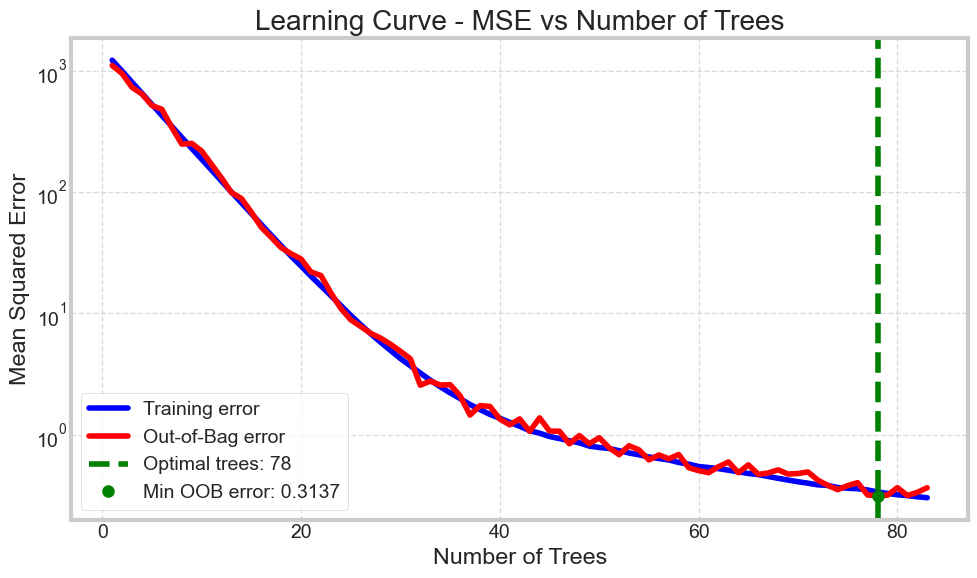

In [467]:
gbrt.plot_learning_curve()

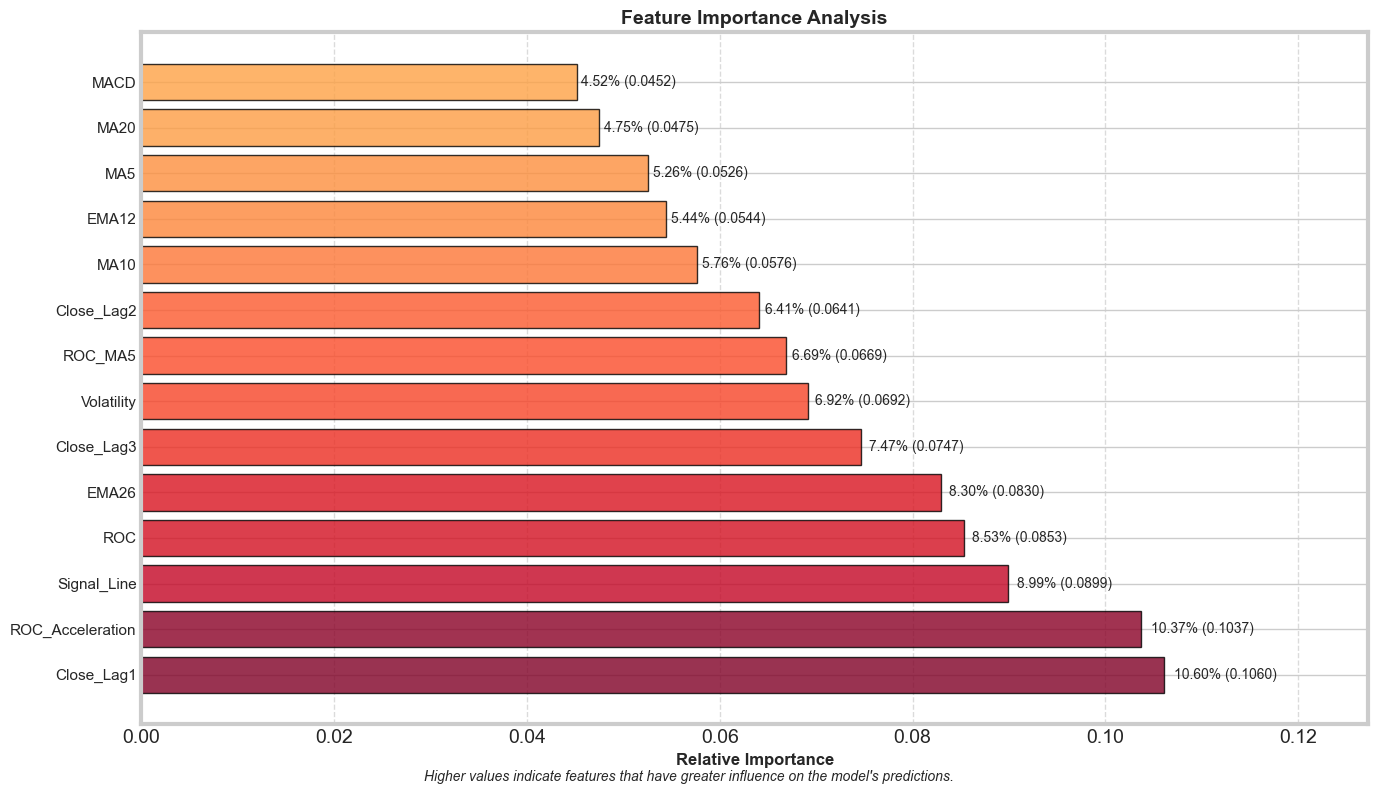

In [468]:
feature_names = df[[col for col in df.columns if col not in ['Close', 'Date']]].columns

feature_importance = gbrt.plot_feature_importance(
    feature_names=feature_names,
    figsize=(14, 8),
)

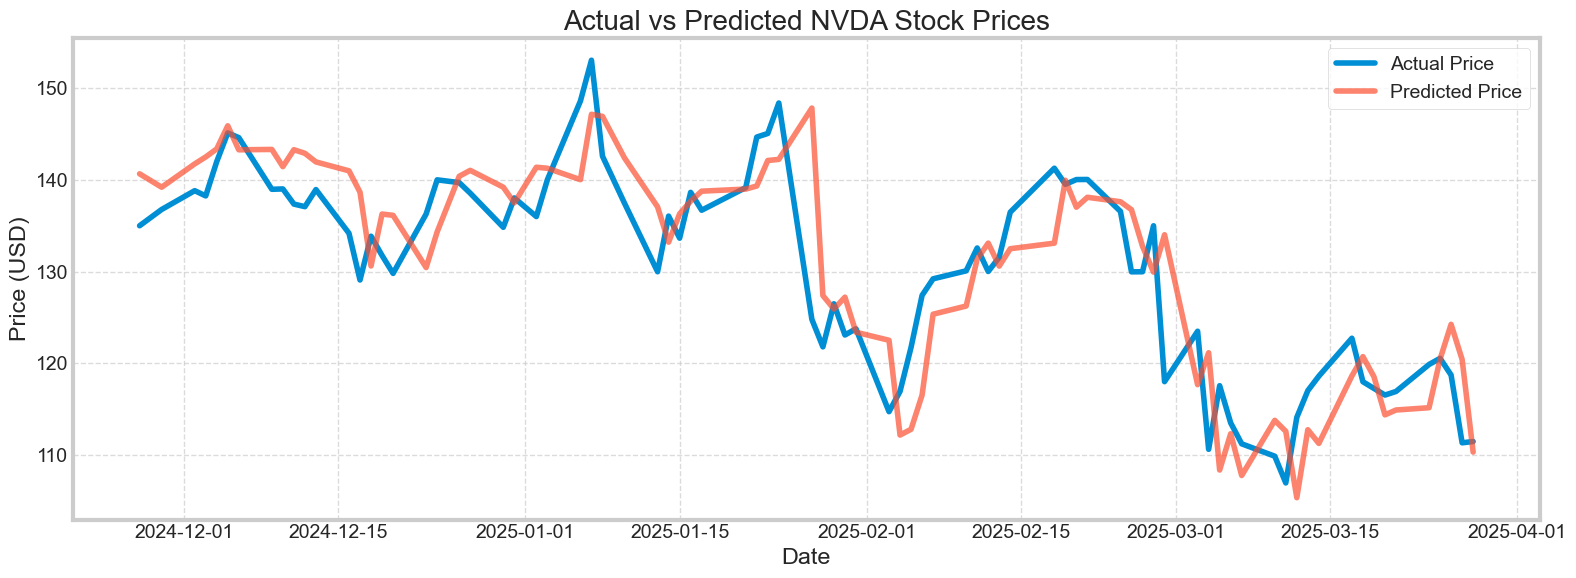

In [469]:
plt.figure(figsize=(16, 6))
plt.title(f'Actual vs Predicted {stock_ticker} Stock Prices')
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Predicts the price of Tesla stock

In [470]:
forecast_days = 60

last_date = df['Date'].iloc[-1]
future_dates = []
current_date = last_date
for _ in range(forecast_days):
  current_date += pd.Timedelta(days=1)
  # Skip weekends
  while current_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
    current_date += pd.Timedelta(days=1)
  future_dates.append(current_date)

# Create dataframe with future dates
future_df = pd.DataFrame({'Date': future_dates})
for col in df.columns:
  if col != 'Date':
    future_df[col] = np.nan

# Create forecast dataframe by combining historical and future data
df_forecast = pd.concat([df, future_df], ignore_index=True)
forecast_start_idx = len(df)

# Generate predictions one day at a time
for i in range(forecast_days):
  current_idx = forecast_start_idx + i
  
  # Update lagged values based on previous predictions
  df_forecast.loc[current_idx, 'Close_Lag1'] = df_forecast.loc[current_idx-1, 'Close']
  df_forecast.loc[current_idx, 'Close_Lag2'] = df_forecast.loc[current_idx-1, 'Close_Lag1']
  df_forecast.loc[current_idx, 'Close_Lag3'] = df_forecast.loc[current_idx-1, 'Close_Lag2']
  
  # Calculate moving averages
  df_forecast.loc[current_idx, 'MA5'] = df_forecast.loc[current_idx-5:current_idx-1, 'Close'].mean()
  df_forecast.loc[current_idx, 'MA10'] = df_forecast.loc[current_idx-10:current_idx-1, 'Close'].mean()
  df_forecast.loc[current_idx, 'MA20'] = df_forecast.loc[current_idx-20:current_idx-1, 'Close'].mean()
  
  # Calculate EMA values
  alpha_12 = 2/(12+1)
  alpha_26 = 2/(26+1)
  alpha_9 = 2/(9+1)
  
  # EMA12 calculation
  df_forecast.loc[current_idx, 'EMA12'] = (
    df_forecast.loc[current_idx-1, 'Close'] * alpha_12 + 
    df_forecast.loc[current_idx-1, 'EMA12'] * (1-alpha_12)
  )
  
  # EMA26 calculation
  df_forecast.loc[current_idx, 'EMA26'] = (
    df_forecast.loc[current_idx-1, 'Close'] * alpha_26 + 
    df_forecast.loc[current_idx-1, 'EMA26'] * (1-alpha_26)
  )
  
  # MACD and Signal Line
  df_forecast.loc[current_idx, 'MACD'] = df_forecast.loc[current_idx, 'EMA12'] - df_forecast.loc[current_idx, 'EMA26']
  df_forecast.loc[current_idx, 'Signal_Line'] = (
    df_forecast.loc[current_idx, 'MACD'] * alpha_9 + 
    df_forecast.loc[current_idx-1, 'Signal_Line'] * (1-alpha_9)
  )
  
  # Volatility
  df_forecast.loc[current_idx, 'Volatility'] = df_forecast.loc[current_idx-10:current_idx-1, 'Close'].std()
  
  # Rate of Change (ROC)
  df_forecast.loc[current_idx, 'ROC'] = (
    (df_forecast.loc[current_idx-1, 'Close'] / df_forecast.loc[current_idx-10, 'Close'] - 1) * 100
  )
  df_forecast.loc[current_idx, 'ROC_Acceleration'] = (
    df_forecast.loc[current_idx, 'ROC'] - df_forecast.loc[current_idx-1, 'ROC']
  )
  df_forecast.loc[current_idx, 'ROC_MA5'] = df_forecast.loc[current_idx-5:current_idx, 'ROC'].mean()
  
  # Make prediction using the trained model
  X_features = df_forecast.loc[current_idx, [col for col in df.columns if col not in ['Close', 'Date']]].values.reshape(1, -1)
  predicted_close = gbrt.predict(X_features)[0]
  
  # Add small random noise for natural variation (0.2%)
  noise = np.random.normal(0, 0.002 * predicted_close)
  df_forecast.loc[current_idx, 'Close'] = predicted_close + noise

# Show the last rows of the forecast
df_forecast.tail()

,Date,Close,Close_Lag1,Close_Lag2,Close_Lag3,MA5,MA10,MA20,EMA12,EMA26,MACD,Signal_Line,Volatility,ROC,ROC_Acceleration,ROC_MA5
596,2025-06-16,143.009831,143.083394,144.067981,143.061381,143.529902,142.990201,141.840102,142.528665,139.215543,3.313122,3.837370,1.127902,0.574702,-0.202078,0.840227
597,2025-06-17,142.786118,143.009831,143.083394,144.067981,143.242051,143.064606,142.177304,142.602690,139.496602,3.106089,3.691114,1.098976,0.499625,-0.075077,0.581005
598,2025-06-18,143.818768,142.786118,143.009831,143.083394,143.201741,143.113330,142.430625,142.630910,139.740269,2.890641,3.531019,1.071717,1.255660,0.756035,0.631738
599,2025-06-19,142.290855,143.818768,142.786118,143.009831,143.353218,143.393663,142.659240,142.813657,140.042380,2.771277,3.379071,0.792173,1.201964,-0.053696,0.825899
600,2025-06-20,141.898107,142.290855,143.818768,142.786118,142.997793,143.411683,142.763266,142.733226,140.208934,2.524292,3.208115,0.761187,-1.570881,-2.772845,0.456308


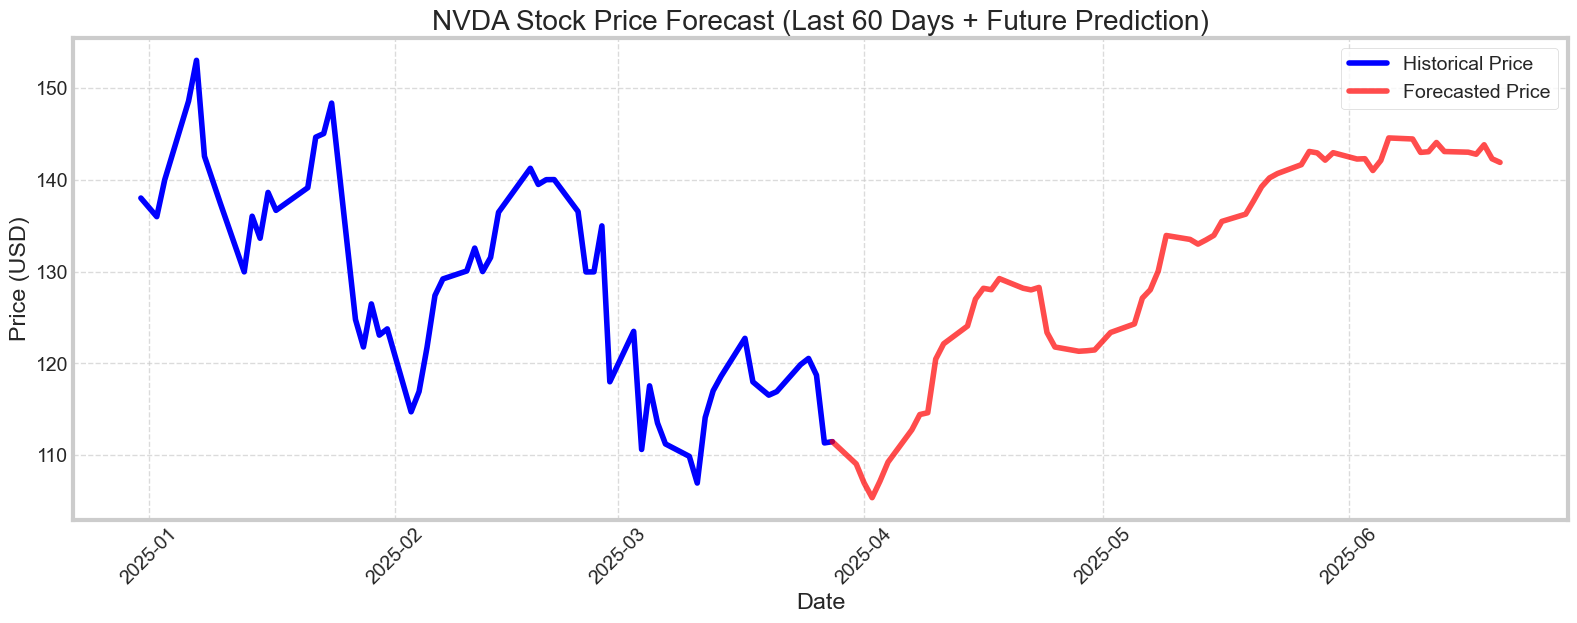

In [471]:
plt.figure(figsize=(16, 6))
plt.title(f'{stock_ticker} Stock Price Forecast (Last 60 Days + Future Prediction)')

# Calculate the start index for showing only last 60 days of historical data
historical_start_idx = max(0, forecast_start_idx - 60)

# Historical price data (last 60 days only)
plt.plot(df_forecast['Date'][historical_start_idx:forecast_start_idx], 
     df_forecast['Close'][historical_start_idx:forecast_start_idx], 
     label='Historical Price', color='blue')

# Forecasted price data
plt.plot(df_forecast['Date'][forecast_start_idx-1:], 
     df_forecast['Close'][forecast_start_idx-1:], 
     label='Forecasted Price', color='red', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()